# Multivariate Time Series Forecasting with LSTMs in Keras
#### Reference: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

### Train On Single Lag Timestep - All meters

In [1]:
from math import sqrt
from numpy import concatenate, savetxt
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM


Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 


In [3]:
# load dataset
#dataset = read_csv('DFS04690650Rand.txt', header=0, index_col=0)
dataset = read_csv('CharlestownAll.csv', header=0, sep='[,]', parse_dates=True, squeeze=True, dayfirst=True, engine='python') 
dataset.drop(dataset.columns[[0]], axis = 1, inplace = True)
values = dataset.values
print(dataset.head())
# ensure all data is float
values = values.astype('float32')
#savetxt('CharlestownValues.csv', values, delimiter=',')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.dtypes
# drop columns we don't want to predict
reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
print(reframed.head())
#shuffle rows
reframed=reframed.sample(frac=1).reset_index(drop=True)
print(reframed.head())

   kWh  MeterNo      Temp  NoBeds  Area_m2  Const_Year  Month  Weekday  \
0  3.0     87.0  8.487500     2.0     73.0      2007.0      4        3   
1  4.0     87.0  9.904167     2.0     73.0      2007.0      4        4   
2  7.0     87.0  7.854167     2.0     73.0      2007.0      4        5   
3  8.0     87.0  8.250000     2.0     73.0      2007.0      4        6   
4  8.0     87.0  8.341667     2.0     73.0      2007.0      4        0   

   Daytime  Holiday  
0        0        0  
1        0        0  
2        0        0  
3        0        0  
4        0        0  
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.082569   0.302817   0.489095   0.333333   0.302326        0.0   
2   0.091743   0.302817   0.557754   0.333333   0.302326        0.0   
3   0.119266   0.302817   0.458401   0.333333   0.302326        0.0   
4   0.128440   0.302817   0.477585   0.333333   0.302326        0.0   
5   0.128440   0.302817   0.482027   0.333333   0.302326        0.0 

# ensure all data is float
values = values.astype('float32')
savetxt('CharlestownValues.csv', values, delimiter=',')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.dtypes

# drop columns we don't want to predict
reframed.drop(reframed.columns[[10,11,12,13,14,16,17,18,19]], axis=1, inplace=True)
print(reframed.head())

#shuffle rows
reframed=reframed.sample(frac=1).reset_index(drop=True)
print(reframed.head())

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.dtypes
# drop columns we don't want to predict
reframed.drop(reframed.columns[[11,12,13,14,15,17,18,19,20,21]], axis=1, inplace=True)
print(reframed.head())

In [4]:
# split into train and test sets
values = reframed.values
n_train_periods = int(len(values)*0.8)
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 


(74388, 1, 10) (74388,) (18597, 1, 10) (18597,)


Train on 74388 samples, validate on 18597 samples
Epoch 1/10
 - 11s - loss: 0.0369 - val_loss: 0.0340
Epoch 2/10
 - 9s - loss: 0.0342 - val_loss: 0.0342
Epoch 3/10
 - 9s - loss: 0.0341 - val_loss: 0.0339
Epoch 4/10
 - 9s - loss: 0.0340 - val_loss: 0.0338
Epoch 5/10
 - 9s - loss: 0.0340 - val_loss: 0.0338
Epoch 6/10
 - 9s - loss: 0.0339 - val_loss: 0.0338
Epoch 7/10
 - 9s - loss: 0.0339 - val_loss: 0.0338
Epoch 8/10
 - 9s - loss: 0.0339 - val_loss: 0.0338
Epoch 9/10
 - 8s - loss: 0.0339 - val_loss: 0.0337
Epoch 10/10
 - 8s - loss: 0.0339 - val_loss: 0.0338


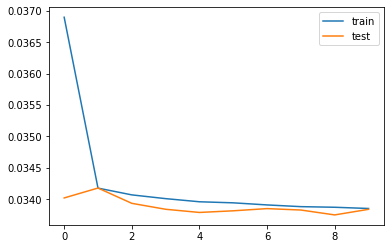

In [5]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
#pyplot.show()
 


In [6]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.606
